In [1]:
import pandas as pd

splits = {'train': 'train.csv', 'validation': 'validation.csv', 'test': 'test.csv'}
df = pd.read_csv("hf://datasets/knkarthick/samsum/" + splits["train"])

## Initial Exploratory Data Analysis (EDA)

To begin understanding the SAMSum dialogue summarization dataset, I performed a series of exploratory steps on the `df` DataFrame, this includes at least two key columns: `dialogue` (the full chat transcript) and `summary` (the human-written condensed version).

### Objectives:
- Identify data quality issues (nulls, duplicates)
- Understand the typical length and structure of dialogues and summaries
- Visualize distribution patterns to guide model configuration
- Calculate the compression ratio expected from the summarization model. In other words the ratio length of the original dialogue vs generated summary model. 

### Key Steps Taken:
1. **Basic Metadata Inspection**  
   - Used `.info()` and `.describe()` to understand dataset shape and schema  
   - Identified any missing or duplicated rows

2. **Length Calculations**  
   - Computed word and character counts for both `dialogue` and `summary` fields  
   - Added new columns: `dialogue_word_count`, `summary_word_count`, `dialogue_char_len`, `summary_char_len`

3. **Distributions of Lengths**  
   - Plotted histograms of dialogue and summary word counts to visualize variability  
   - Used KDE curves to understand central tendencies and outliers

4. **Compression Ratio**  
   - Calculated the ratio of `dialogue_word_count` to `summary_word_count`  
   - This gives a sense of how much information the model is expected to distill

5. **Qualitative Sample Inspection**  
   - Printed a few examples of dialogues and their associated summaries for manual review  
   - Helped ensure summaries are actually abstractive and aligned with model goals

This initial EDA provides a foundation for designing an appropriate model architecture and choosing suitable sequence lengths for input and output during training.

In [4]:
df.info()
df.describe(include='object')
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14732 entries, 0 to 14731
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        14732 non-null  object
 1   dialogue  14731 non-null  object
 2   summary   14732 non-null  object
dtypes: object(3)
memory usage: 345.4+ KB


id                                           dialogue  \
0  13818513  Amanda: I baked  cookies. Do you want some?\nJ...   
1  13728867  Olivia: Who are you voting for in this electio...   
2  13681000  Tim: Hi, what's up?\nKim: Bad mood tbh, I was ...   
3  13730747  Edward: Rachel, I think I'm in ove with Bella....   
4  13728094  Sam: hey  overheard rick say something\nSam: i...   

                                             summary  
0  Amanda baked cookies and will bring Jerry some...  
1  Olivia and Olivier are voting for liberals in ...  
2  Kim may try the pomodoro technique recommended...  
3  Edward thinks he is in love with Bella. Rachel...  
4  Sam is confused, because he overheard Rick com...

In [6]:
print("Missing values \n", df.isnull().sum())
print("Duplicates:", df.duplicated().sum())

Missing values 
 id          0
dialogue    1
summary     0
dtype: int64
Duplicates: 0


In [18]:
# Add word and token length columns
df = df.dropna(subset=['dialogue'])
df['dialogue_word_count'] = df['dialogue'].apply(lambda x: len(x.split()))
df['summary_word_count'] = df['summary'].apply(lambda x: len(x.split()))

# Character length
df['dialogue_char_len'] = df['dialogue'].str.len()
df['summary_char_len'] = df['summary'].str.len()

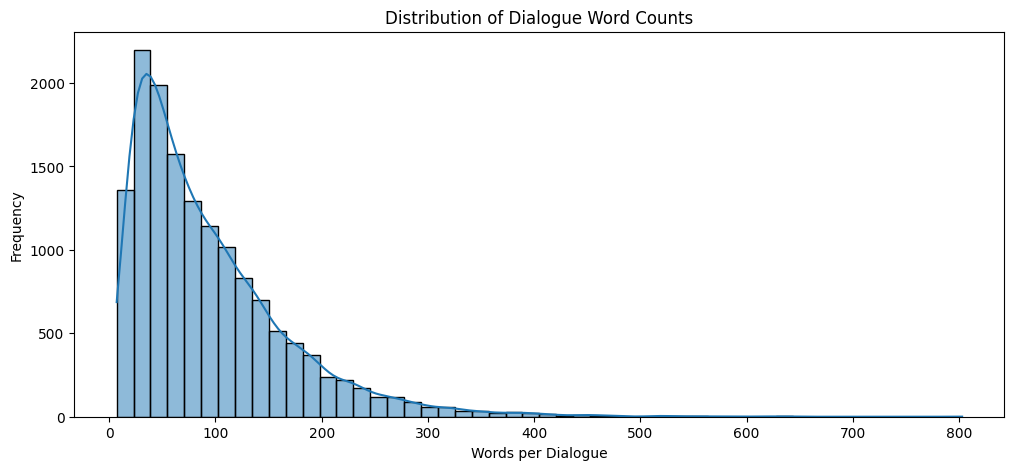

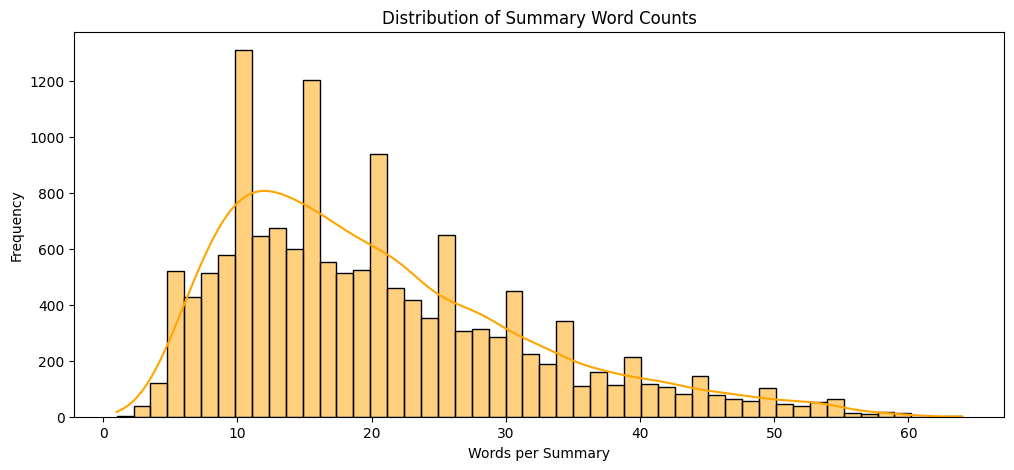

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 5))
sns.histplot(df['dialogue_word_count'], bins=50, kde=True)
plt.title("Distribution of Dialogue Word Counts")
plt.xlabel("Words per Dialogue")
plt.ylabel("Frequency")
plt.show()

plt.figure(figsize=(12, 5))
sns.histplot(df['summary_word_count'], bins=50, kde=True, color='orange')
plt.title("Distribution of Summary Word Counts")
plt.xlabel("Words per Summary")
plt.ylabel("Frequency")
plt.show()

In [21]:
df['compression_ratio'] = df['dialogue_word_count'] / df['summary_word_count']
df['compression_ratio'].describe()

count    14731.000000
mean         4.842780
std          3.550485
min          0.529412
25%          2.636364
50%          3.900000
75%          5.875000
max         65.000000
Name: compression_ratio, dtype: float64

In [22]:
for i in range(3):
    print(f"\n--- DIALOGUE #{i+1} ---\n{df['dialogue'].iloc[i]}")
    print(f"\n--- SUMMARY #{i+1} ---\n{df['summary'].iloc[i]}")


--- DIALOGUE #1 ---
Amanda: I baked  cookies. Do you want some?
Jerry: Sure!
Amanda: I'll bring you tomorrow :-)

--- SUMMARY #1 ---
Amanda baked cookies and will bring Jerry some tomorrow.

--- DIALOGUE #2 ---
Olivia: Who are you voting for in this election? 
Oliver: Liberals as always.
Olivia: Me too!!
Oliver: Great

--- SUMMARY #2 ---
Olivia and Olivier are voting for liberals in this election. 

--- DIALOGUE #3 ---
Tim: Hi, what's up?
Kim: Bad mood tbh, I was going to do lots of stuff but ended up procrastinating
Tim: What did you plan on doing?
Kim: Oh you know, uni stuff and unfucking my room
Kim: Maybe tomorrow I'll move my ass and do everything
Kim: We were going to defrost a fridge so instead of shopping I'll eat some defrosted veggies
Tim: For doing stuff I recommend Pomodoro technique where u use breaks for doing chores
Tim: It really helps
Kim: thanks, maybe I'll do that
Tim: I also like using post-its in kaban style

--- SUMMARY #3 ---
Kim may try the pomodoro technique r